# Титаник

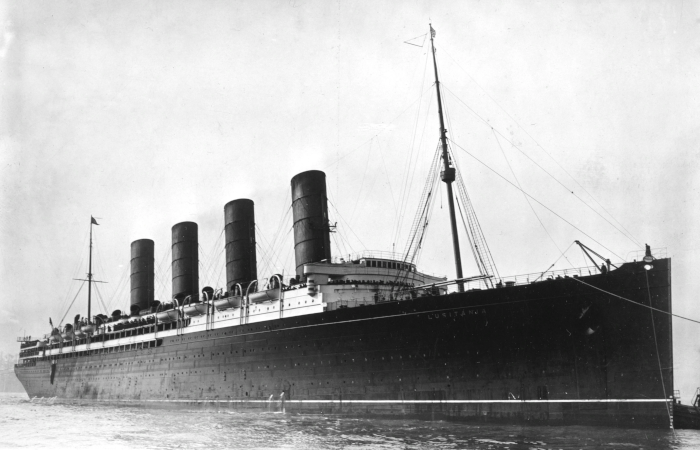

Набор от данни съдържащ информация за пътници, пътували на Титаник.

## Прочитане на данните

In [ ]:
import pandas as pd

data = pd.read_csv('titanic_data.csv')

## Подготовка и изследване на данните

Извеждаме първите 5 реда от данните.

In [ ]:
data.head(5)

Структура на данните:
* PassengerId - идентификационен номер на пътника
* Survived - оживял или не (0 или 1)
* Pclass - пътническа класа: 1 - първа, 2 - втора, 3 - трета
* Name - име на пътника
* Sex - пол на пътника: male или female
* Age - възраст на пътника
* SibSp - брой на братя/сестри или съпруг/съпруга на борда
* Parch - брой родители и деца на борда
* Ticket - номер на билет
* Fare - Цена на билета
* Cabin - номер каюта
* Embarked - пристанище на тръгване: C = Cherbourg, Q = Queenstown, S = Southampton

Количество на данните. Може да се види, че имаме 891 записа и 12 колони в нашите данни:

In [ ]:
data.shape

In [ ]:
data.info()

Виждаме, че възрастта липсва на доста хора (117 човека нямат зададена възраст), както и номера на каютата (има информация само за 204 от 891). Можем да проверим колко данни липсват по следния начин:

In [ ]:
data.isnull().sum()

Зареждаме необходимите библиотеки:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Стълбовидна диаграма на категорийните характеристики:

* Pclass
* Sex
* Embarked
* Cabin

In [ ]:
def bar_chart(feature):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Оцелели','Загинали']
    df.plot(kind='bar')

Диаграма по пол:

In [ ]:
bar_chart('Sex')

От горната диаграма се вижда, че жените имат по-голям шанс за оцеляване.

Следва диаграма по пътническа класа:

In [ ]:
bar_chart('Pclass')

От диаграмата се вижда, че пътниците в първа класа имат по-голям шанс да оцелеят, а пътниците от трета класа имат голям шанс да загинат.

Диаграма по място на отпътуване:

In [ ]:
bar_chart('Embarked')

От диаграмата може да се забележи, че хората от S и Q по-вероятно са загинали а хората от C малко по-вероятно да се оцелели.

### Инженеринг на характеристиките (feature engineering)

Инженерингът на характеристиките е процесът на използване на знания за домейна на данните за създаване на характеристики (вектори на характеристики), които се използват от алгоритмите за машинно обучение.

Вектор на характеристиките е n-измерен вектор от числени характеристики, които представят някакъв обект. Алгоритмите в машинното обучение изискват цифрово представяне на обектите.

#### Pclass

От данните се вижда, че пътническата класа е важна характеристика за класификатора.

#### Name

In [ ]:
data.head()

Името на хората не е важно, но титлата може да има някакво значение за класификатора. Ще създадем нова колона / поле в нашите данни с титлата на съответния човек, която ще извадим от името:

In [ ]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

data['Title'].value_counts()

Преобразуваме текстовото поле `Title` в цифрово, като заменяме титлата по следния начин:

Miss, Mlle, Ms: 1

Mrs, Mme: 2

Mr: 3

Others: 4

In [ ]:
title_mapping = {"Miss": 1, "Mlle": 1, "Ms": 1,  "Mrs": 2, "Mme": 2, "Mr": 3,
                 "Master": 4, "Dr": 4, "Rev": 4, "Col": 4, "Major": 4, "Countess": 4,
                 "Lady": 4, "Jonkheer": 4, "Don": 4, "Dona" : 4, "Capt": 3,"Sir": 4 }
data['Title'] = data['Title'].map(title_mapping)

data['Title'].value_counts()

In [ ]:
data.head()

Ще изведем диаграма по титла:

In [ ]:
bar_chart('Title')

Изтриваме полето `Name` от данните, понеже вече не ни трябва:

In [ ]:
data.drop('Name', axis=1, inplace=True)

data.head()

#### Sex

Заменяме:

male: 0

female: 1

In [ ]:
sex_mapping = {"male": 0, "female": 1}
data['Sex'] = data['Sex'].map(sex_mapping)

data.head()

In [ ]:
bar_chart('Sex')

#### Age

При някои записи липсва възрастта:

In [ ]:
data.head(20)

In [ ]:
data["Age"].fillna(data.groupby("Title")["Age"].transform("median"), inplace=True)

data.head(20)

In [ ]:
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill=True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()
 
plt.show() 

Полето за възраст го конвертираме към категория, като ги разделяме по следния начин:

child: 0 (0 < Age <= 16)

young: 1 (16 < Age <= 26)

adult: 2 (26 < Age <= 36)

mid-age: 3 (36 < Age <= 62)

senior: 4 (62 < Age)

In [ ]:
data.loc[ data['Age'] <= 16, 'Age'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 26), 'Age'] = 1
data.loc[(data['Age'] > 26) & (data['Age'] <= 36), 'Age'] = 2
data.loc[(data['Age'] > 36) & (data['Age'] <= 62), 'Age'] = 3
data.loc[ data['Age'] > 62, 'Age'] = 4

data.head()

In [ ]:
bar_chart('Age')

#### Embarked

Празните стойности го попълваме със `S` като най-популярното пристанище за отпътуване.

In [ ]:
data['Embarked'] = data['Embarked'].fillna('S')

Заменяваме категориите с цифрови стойности:

S: 0

C: 1

Q: 2

In [ ]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
data['Embarked'] = data['Embarked'].map(embarked_mapping)

data.head()

#### Fare

За празните полета за цена използваме средното аритметично за съответната пътническа класа:

In [ ]:
data["Fare"].fillna(data.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [ ]:
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',fill=True)
facet.set(xlim=(0, data['Fare'].max()))
facet.add_legend()
 
plt.show()  

#### Cabin

За доста от записите липсва информация за номер на каюта.

In [ ]:
data.Cabin.value_counts()

Можем да изпозлваме само кода на каютата без номера:

In [ ]:
data['Cabin'] = data['Cabin'].str[:1]

data.Cabin.value_counts()

Заместваме буквите с числа:

In [ ]:
cabin_mapping = {"A": 0, "B": 0.5, "C": 1.0, "D": 1.5, "E": 2.0, "F": 2.5, "G": 3.0, "T": 3.5}
data['Cabin'] = data['Cabin'].map(cabin_mapping)

data.head()

За записите без каюта, изпозлваме средно аритметично за съответната класа:

In [ ]:
data["Cabin"].fillna(data.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

data.head()

#### FamilySize

Двете полета `SibSp` и `Parch` можем да ги обединим в едно ново поле FamilySize:

In [ ]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1

data.head()

#### Премахваме ненужните характеристики

In [ ]:
features_drop = ['PassengerId', 'Ticket', 'SibSp', 'Parch']
data = data.drop(features_drop, axis=1)

data.head()


Вече всички характеристики са цифрови и можем да ги използваме в ML модели.

## Моделиране на данните

Ще създадем няколко различни класификатора и ще тестваме тяхната точност.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np

In [ ]:
data.info()

In [ ]:
train_data = data.drop('Survived', axis=1)
labels = data['Survived']

print(train_data.shape)
print(labels.shape)

### Крос валидация (k-fold)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

### k-nearest neighbors класификатор

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, labels, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

Средна точност:

In [ ]:
round(np.mean(score)*100, 2)

### Decision Tree класификатор

In [ ]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, labels, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

Средна точност:

In [ ]:
round(np.mean(score)*100, 2)

### Ramdom Forest класификатор

In [ ]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, labels, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

Средна точност:

In [ ]:
round(np.mean(score)*100, 2)

### Класификатор с Невронна мрежа

In [ ]:
import torch
from torch import nn

In [ ]:
class Net(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.fc1 = nn.Linear(in_features, 10)
    self.output = nn.Linear(10, out_features)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.sigmoid(self.output(x))
    return x

def reset_weights(m):
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [ ]:
train_features = torch.tensor(data.values, dtype=torch.float32)
train_labels = torch.tensor(labels.values, dtype=torch.float32)

In [ ]:
num_epochs = 10
batch_size = 10
learning_rate = 0.001

loss = nn.BCELoss()
in_features = train_features.shape[1]

train_ls = []
dataset = torch.utils.data.TensorDataset(train_features, train_labels.view(-1,1))

results = {}
for fold, (train_ids, test_ids) in enumerate(k_fold.split(dataset)):
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  train_loader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=batch_size, sampler=train_subsampler)
  test_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size, sampler=test_subsampler)

  net = Net(in_features, 1)
  net.apply(reset_weights)
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  cur_loss = 0.0
  for epoch in range(num_epochs):
    for X, y in train_loader:
      optimizer.zero_grad()
      output = net(X)
      l = loss(output, y)
      l.backward()
      optimizer.step()
      train_ls.append(l.item())
      cur_loss+=l.item()

  correct, total = 0, 0
  with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
      X, y = data
      preds = (net(X).detach().numpy() > 0.5).astype(np.int32)
      correct += np.count_nonzero(preds==y.numpy().astype(np.int32))
      total += y.size(0)

    # Print accuracy
    print('Accuracy for fold %d: %.2f%%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

sum = 0.0
for key, value in results.items():
  sum += value
print('Average accuracy: %.2f%%' % (sum/len(results.items())))